<a href="https://colab.research.google.com/github/Zardian18/Energy-Based-MNIST/blob/master/EBM_Mnist_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-22 06:48:24--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-01-22 06:48:24 (27.3 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
from tensorflow.keras import datasets

(x_train,_), (x_test, _)= datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_test.shape

(10000, 28, 28)

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
import tensorflow as tf
from helper import display, sample_batch
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

def preprocess(imgs):
  imgs = (imgs.astype("float32")-127.5)/127.5
  imgs = np.pad(imgs, ((0,0),(2,2),(2,2)), constant_values=-1.0)
  imgs = np.expand_dims(imgs, axis=-1)
  return imgs

In [6]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [7]:
x_train.shape

(60000, 32, 32, 1)

In [8]:
x_test.shape

(10000, 32, 32, 1)

In [9]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(128)

In [10]:
x_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None)>

In [11]:
x_test

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None)>

## The Energy Function

In [12]:
ebm_input = layers.Input(shape=(32,32,1))
x = layers.Conv2D(16, 5, strides =2, padding="same", activation=activations.swish)(ebm_input)
x = layers.Conv2D(32, 3, strides =2, padding="same", activation=activations.swish)(x)
x = layers.Conv2D(64, 3, strides =2, padding="same", activation=activations.swish)(x)
x = layers.Conv2D(64, 3, strides =2, padding="same", activation=activations.swish)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [13]:
def generate_samples(model, inp_imgs, steps, step_size, noise, return_imgs_per_step=False):
  imgs_per_step=[]
  for _ in range(steps):
    inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise) # adding to input of the neural netowrk as the weights dont change
    inp_imgs = tf.clip_by_value(inp_imgs, -1.0,1.0) # basically preprocessing
    with tf.GradientTape() as tape:
      tape.watch(inp_imgs)
      out_score= -model(inp_imgs)
    grads = tape.gradient(out_score, inp_imgs) # therefore here we change inp_imgs instead of self.trainable_variables
    grads = tf.clip_by_value(grads, -0.03,0.03) # gradient clip
    inp_imgs += -step_size*grads
    inp_imgs = tf.clip_by_value(inp_imgs, -1.0,1.0)
    if return_imgs_per_step:
      imgs_per_step.append(inp_imgs)

  if return_imgs_per_step:
    return tf.stack(imgs_per_step, axis=0)

  else:
    return inp_imgs

## Buffer

This generates lower and higher values fofr energy function for real and fake observations respectively

In [14]:
class Buffer:
  def __init__(self, model):
    super().__init__()
    self.model = model
    self.examples=[
        tf.random.uniform(shape=(1,32,32,1))*2 -1
        for _ in range(128) # batch size
    ]

  def sample_new_exmps(self, steps, step_size, noise):
    n_new = np.random.binomial(128, 0.05) # generating from scratch, only 5% tho
    rand_imgs = (
        tf.random.uniform((n_new, 32, 32, 1))*2 -1
    )

    old_imgs = tf.concat(random.choices(self.examples, k=128 - n_new), axis=0)
    inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
    inp_imgs = generate_samples(self.model, inp_imgs, steps=steps, step_size = step_size, noise= noise)
    self.examples = tf.split(inp_imgs, 128, axis=0) + self.examples
    self.examples = self.examples[:8192] # buffer size
    return inp_imgs

## Setting up the model and training

In [25]:
class EBM(models.Model):
  def __init__(self):
    super(EBM, self).__init__()
    self.model = model
    self.buffer = Buffer(self.model)
    self.alpha = 0.1
    self.loss_metric = metrics.Mean(name="loss")
    self.reg_loss_metric = metrics.Mean(name="reg")
    self.cdiv_loss_metric= metrics.Mean(name="cdiv")
    self.real_out_metric = metrics.Mean(name="real")
    self.fake_out_metric = metrics.Mean(name="fake")

  @property
  def metrics(self):
    return[
        self.loss_metric,
        self.reg_loss_metric,
        self.cdiv_loss_metric,
        self.real_out_metric,
        self.fake_out_metric
    ]

  def train_steps(self, real_imgs):
    real_imgs +=  tf.random.normal(shape= tf.shape(real_imgs), mean =0, stddev = 0.005)
    real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
    fake_imgs = self.buffer.sample_new_exmps(steps=60, step_size= 10, noise= 0.005)
    inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
    with tf.GradientTape() as training_tape:
      real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
      cdiv_loss = tf.reduce_mean(fake_out, axis =0)- tf.reduce_mean(real_out, axis=0)
      reg_loss = self.alpha* tf.reduce_mean(real_out**2 + fake_out**2, axis=0)
      loss = reg_loss + cdiv_loss

    grads = training_tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    self.loss_metric.update_state(loss)
    self.reg_loss_metric.update_state(reg_loss)
    self.cdiv_loss_metric.update_state(cdiv_loss)
    self.real_out_metric.update_state(tf.reduce_mean(real_out, axis = 0))
    self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis = 0))

    return {m.name: m.result() for m in self.metrics}

  def test_step(self, real_imgs):
    batch_size = real_imgs.shape[0]
    fake_imgs = tf.random.uniform((batch_size, 32, 32, 1)) * 2 - 1
    inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
    real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
    cdiv = tf.reduce_mean(fake_out, axis = 0) - tf.reduce_mean(
    real_out, axis = 0
    )
    self.cdiv_loss_metric.update_state(cdiv)
    self.real_out_metric.update_state(tf.reduce_mean(real_out, axis = 0))
    self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis = 0))
    return {m.name: m.result() for m in self.metrics[2:]}

In [29]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [30]:
#####
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [31]:
ebm = EBM()

In [32]:
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), run_eagerly=True
)

In [37]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, 32, 32, 1)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=10,
            noise=0.005,
            return_imgs_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [21]:
# class SaveModel(callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         model.save_weights("./models/model.h5")


# save_model_callback = SaveModel()

In [22]:
! mkdir output/

Epoch 1/60
469/469 [==============================] - ETA: 0s - loss: -0.0010 - reg: 9.8737e-04 - cdiv: -0.0020 - real: 0.0033 - fake: 0.0014
Saved to ./output/generated_img_000.png


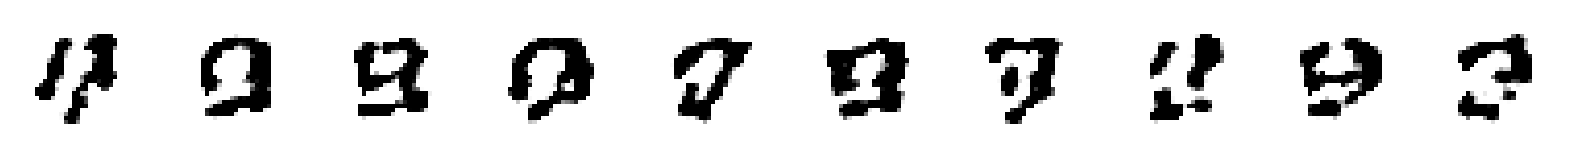


Saved to ./output/example_img_000.png


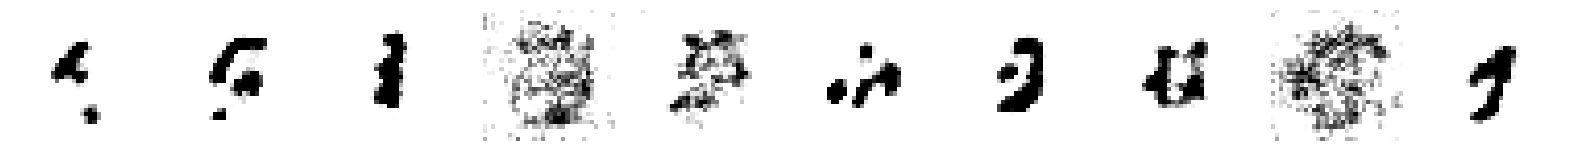

469/469 [==============================] - 569s 1s/step - loss: -0.0010 - reg: 9.8737e-04 - cdiv: -0.0020 - real: 0.0033 - fake: 0.0014 - val_cdiv: -1.8734 - val_real: -0.0494 - val_fake: -1.9228
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: -4.1490e-04 - reg: 6.9763e-04 - cdiv: -0.0011 - real: 0.0027 - fake: 0.0015
Saved to ./output/generated_img_001.png


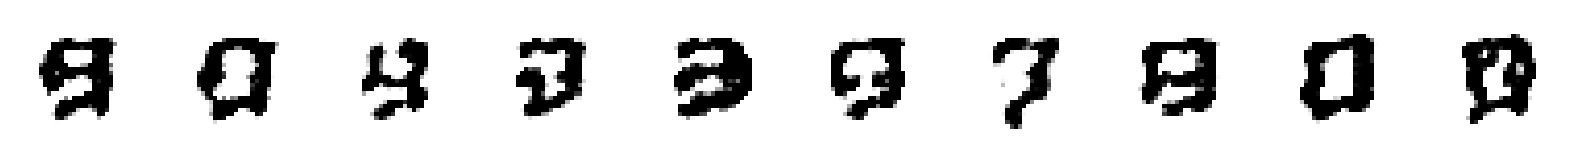


Saved to ./output/example_img_001.png


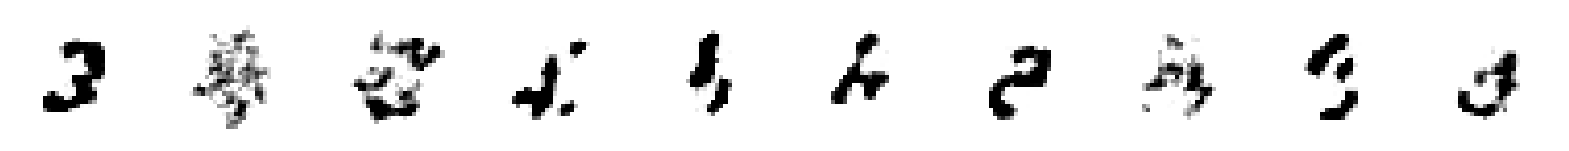

469/469 [==============================] - 565s 1s/step - loss: -4.1490e-04 - reg: 6.9763e-04 - cdiv: -0.0011 - real: 0.0027 - fake: 0.0015 - val_cdiv: -2.1312 - val_real: -0.0443 - val_fake: -2.1755
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: 9.0358e-05 - reg: 4.3326e-04 - cdiv: -3.4290e-04 - real: 0.0020 - fake: 0.0017
Saved to ./output/generated_img_002.png


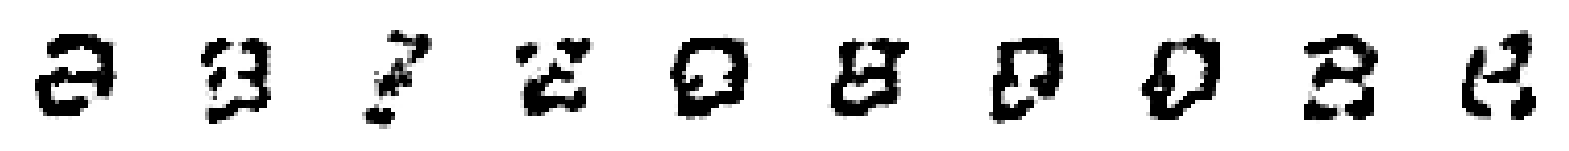


Saved to ./output/example_img_002.png


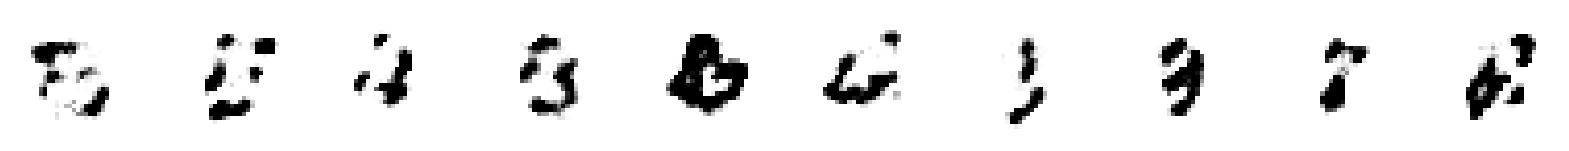

469/469 [==============================] - 570s 1s/step - loss: 9.0358e-05 - reg: 4.3326e-04 - cdiv: -3.4290e-04 - real: 0.0020 - fake: 0.0017 - val_cdiv: -2.4207 - val_real: -0.0259 - val_fake: -2.4466
Epoch 4/60
469/469 [==============================] - ETA: 0s - loss: -1.2774e-04 - reg: 2.9848e-04 - cdiv: -4.2622e-04 - real: 0.0020 - fake: 0.0015
Saved to ./output/generated_img_003.png


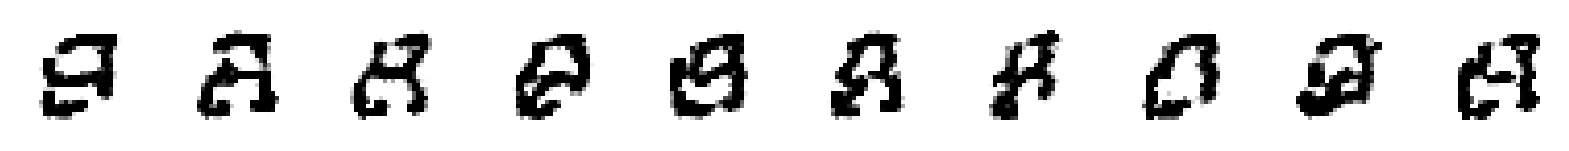


Saved to ./output/example_img_003.png


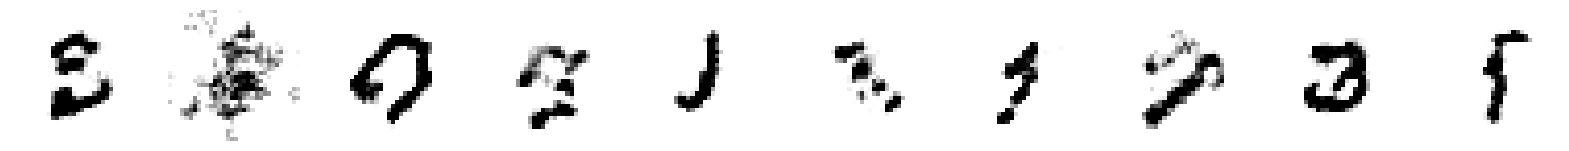

469/469 [==============================] - 572s 1s/step - loss: -1.2774e-04 - reg: 2.9848e-04 - cdiv: -4.2622e-04 - real: 0.0020 - fake: 0.0015 - val_cdiv: -2.7836 - val_real: -0.0194 - val_fake: -2.8030
Epoch 5/60
469/469 [==============================] - ETA: 0s - loss: 4.7194e-04 - reg: 2.2939e-04 - cdiv: 2.4255e-04 - real: 8.6190e-04 - fake: 0.0011
Saved to ./output/generated_img_004.png


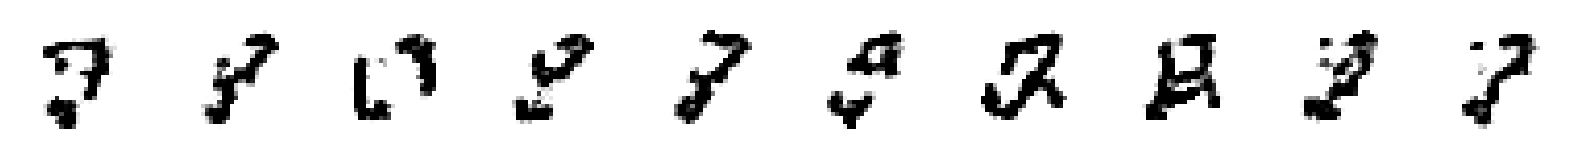


Saved to ./output/example_img_004.png


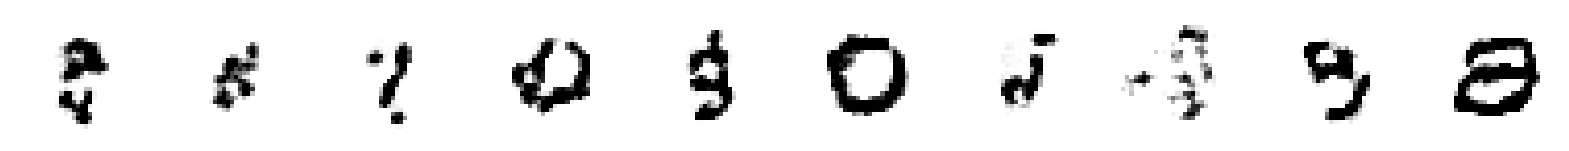

469/469 [==============================] - 576s 1s/step - loss: 4.7194e-04 - reg: 2.2939e-04 - cdiv: 2.4255e-04 - real: 8.6190e-04 - fake: 0.0011 - val_cdiv: -3.0263 - val_real: -0.0085 - val_fake: -3.0348
Epoch 6/60
469/469 [==============================] - ETA: 0s - loss: 2.3843e-04 - reg: 2.4121e-04 - cdiv: -2.7757e-06 - real: 7.5707e-04 - fake: 7.5429e-04
Saved to ./output/generated_img_005.png


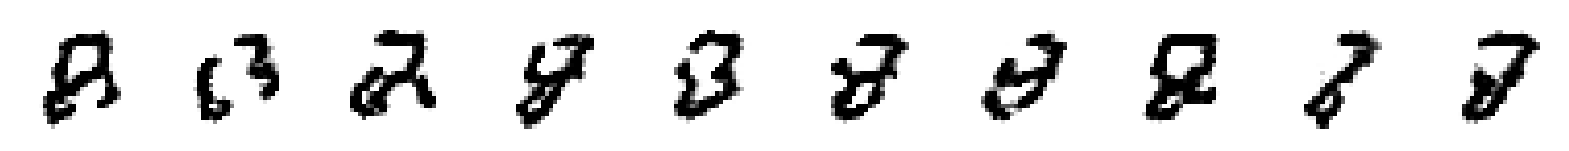


Saved to ./output/example_img_005.png


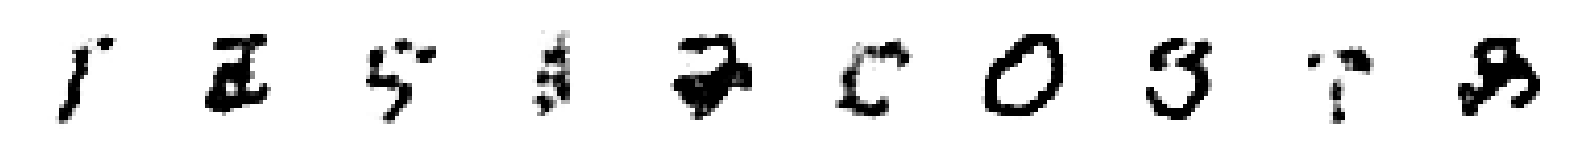

469/469 [==============================] - 561s 1s/step - loss: 2.3843e-04 - reg: 2.4121e-04 - cdiv: -2.7757e-06 - real: 7.5707e-04 - fake: 7.5429e-04 - val_cdiv: -3.2133 - val_real: -0.0188 - val_fake: -3.2322
Epoch 7/60
469/469 [==============================] - ETA: 0s - loss: -2.1375e-04 - reg: 2.5907e-04 - cdiv: -4.7282e-04 - real: 9.6709e-04 - fake: 4.9428e-04
Saved to ./output/generated_img_006.png


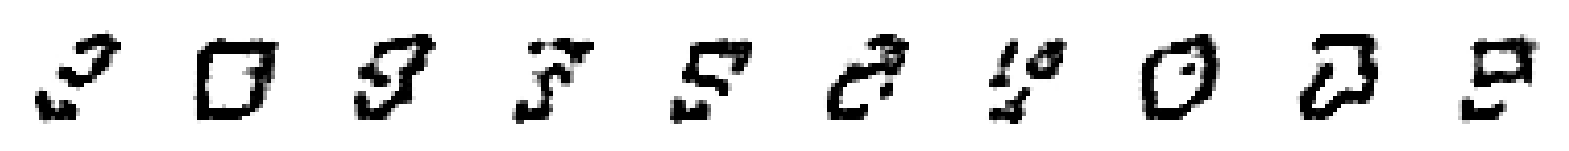


Saved to ./output/example_img_006.png


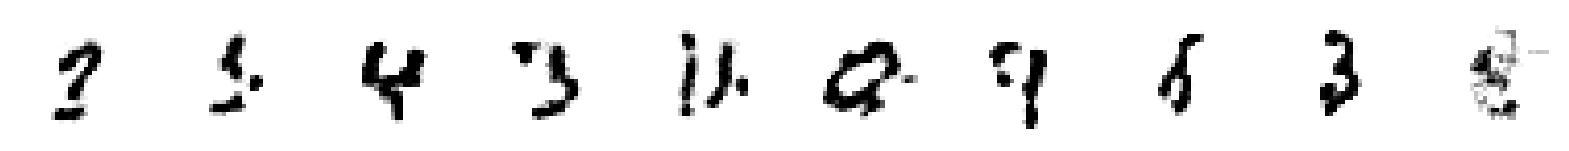

469/469 [==============================] - 559s 1s/step - loss: -2.1375e-04 - reg: 2.5907e-04 - cdiv: -4.7282e-04 - real: 9.6709e-04 - fake: 4.9428e-04 - val_cdiv: -3.6884 - val_real: -0.0080 - val_fake: -3.6964
Epoch 8/60
469/469 [==============================] - ETA: 0s - loss: 1.1590e-04 - reg: 2.8271e-04 - cdiv: -1.6681e-04 - real: 9.2142e-04 - fake: 7.5461e-04
Saved to ./output/generated_img_007.png


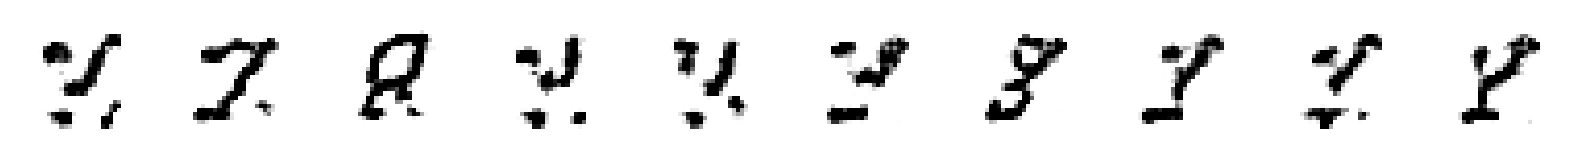


Saved to ./output/example_img_007.png


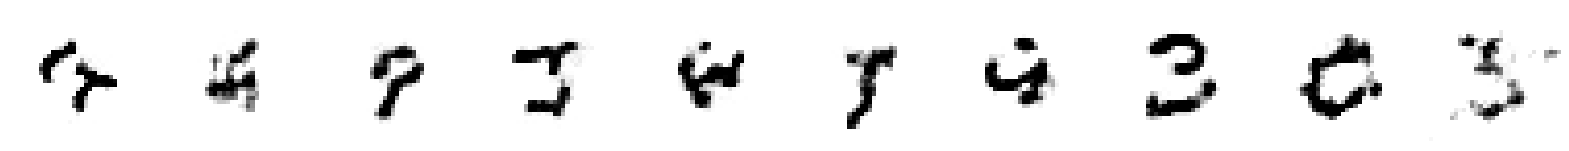

469/469 [==============================] - 563s 1s/step - loss: 1.1590e-04 - reg: 2.8271e-04 - cdiv: -1.6681e-04 - real: 9.2142e-04 - fake: 7.5461e-04 - val_cdiv: -4.0544 - val_real: -0.0126 - val_fake: -4.0670
Epoch 9/60
469/469 [==============================] - ETA: 0s - loss: -2.1901e-05 - reg: 2.7535e-04 - cdiv: -2.9726e-04 - real: 7.4928e-04 - fake: 4.5203e-04
Saved to ./output/generated_img_008.png


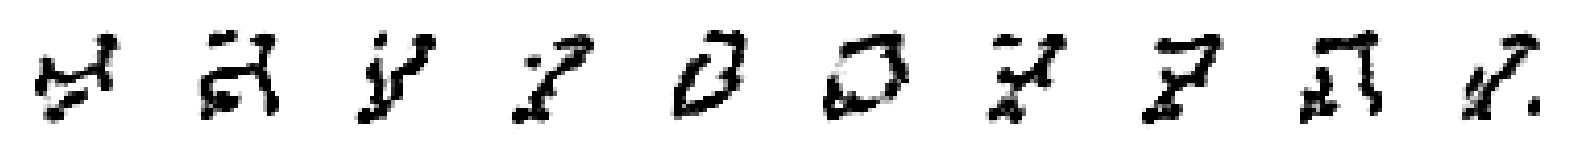


Saved to ./output/example_img_008.png


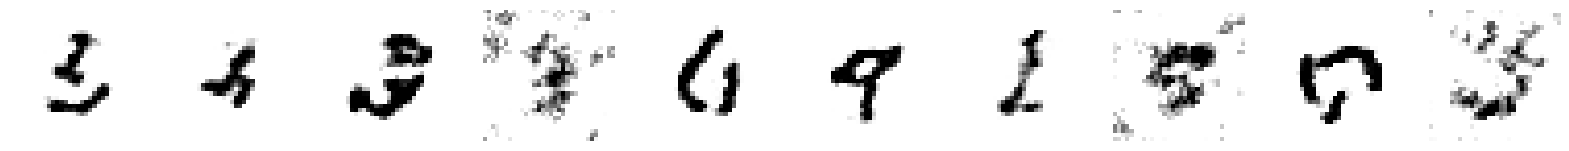

469/469 [==============================] - 559s 1s/step - loss: -2.1901e-05 - reg: 2.7535e-04 - cdiv: -2.9726e-04 - real: 7.4928e-04 - fake: 4.5203e-04 - val_cdiv: -4.3652 - val_real: 0.0094 - val_fake: -4.3558
Epoch 10/60
469/469 [==============================] - ETA: 0s - loss: 4.1203e-05 - reg: 2.6851e-04 - cdiv: -2.2731e-04 - real: 6.1565e-04 - fake: 3.8833e-04
Saved to ./output/generated_img_009.png


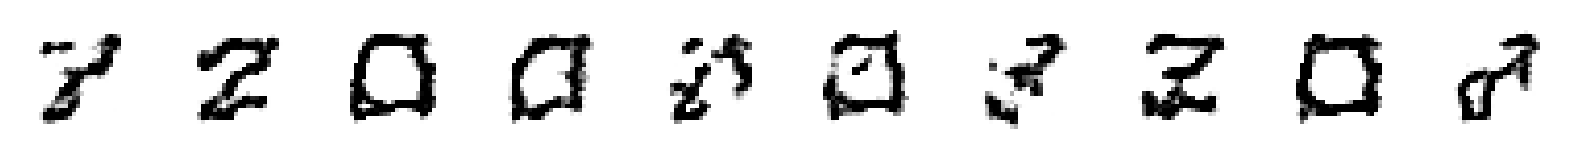


Saved to ./output/example_img_009.png


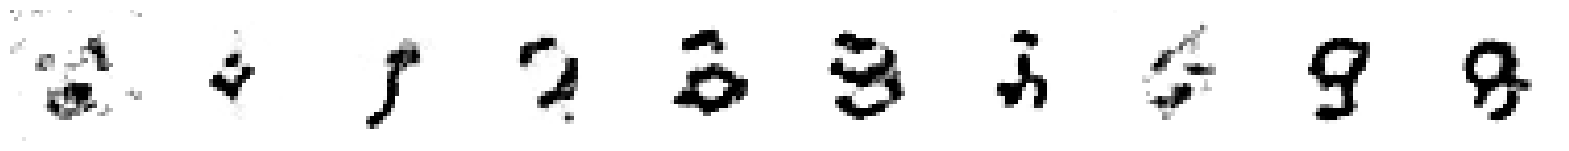

469/469 [==============================] - 559s 1s/step - loss: 4.1203e-05 - reg: 2.6851e-04 - cdiv: -2.2731e-04 - real: 6.1565e-04 - fake: 3.8833e-04 - val_cdiv: -4.7113 - val_real: 0.0207 - val_fake: -4.6906
Epoch 11/60
469/469 [==============================] - ETA: 0s - loss: -9.5549e-05 - reg: 3.1489e-04 - cdiv: -4.1043e-04 - real: 6.3313e-04 - fake: 2.2270e-04
Saved to ./output/generated_img_010.png


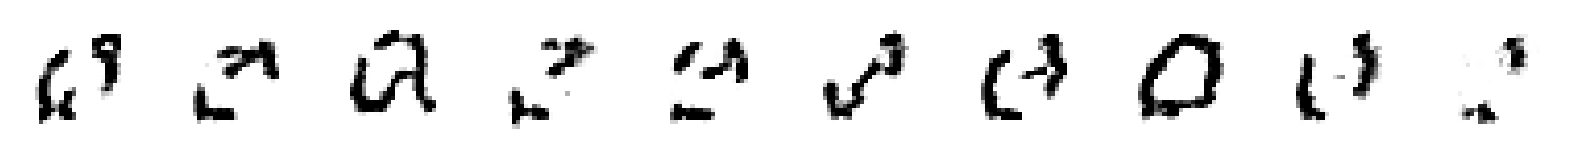


Saved to ./output/example_img_010.png


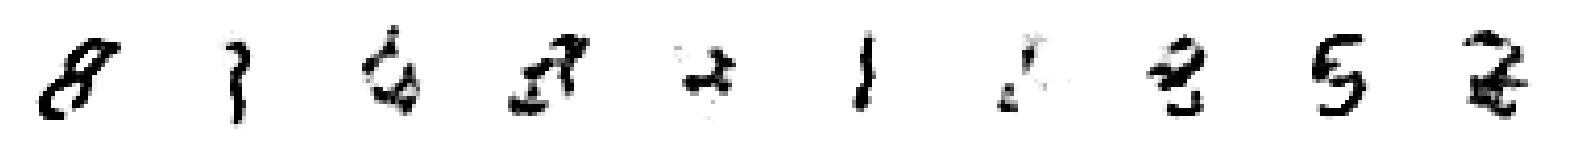

469/469 [==============================] - 560s 1s/step - loss: -9.5549e-05 - reg: 3.1489e-04 - cdiv: -4.1043e-04 - real: 6.3313e-04 - fake: 2.2270e-04 - val_cdiv: -5.1604 - val_real: 0.0202 - val_fake: -5.1402
Epoch 12/60
469/469 [==============================] - ETA: 0s - loss: -2.3645e-05 - reg: 2.4058e-04 - cdiv: -2.6422e-04 - real: 5.0584e-04 - fake: 2.4162e-04
Saved to ./output/generated_img_011.png


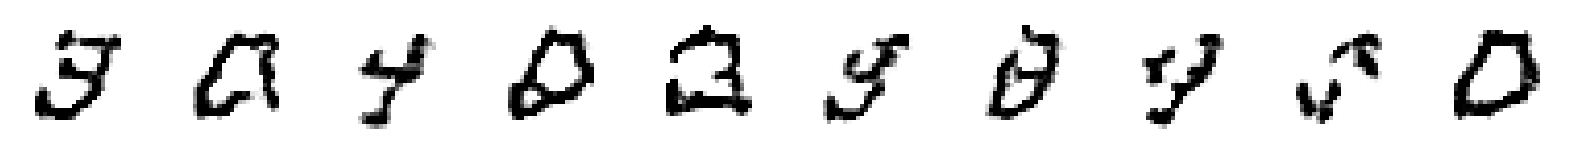


Saved to ./output/example_img_011.png


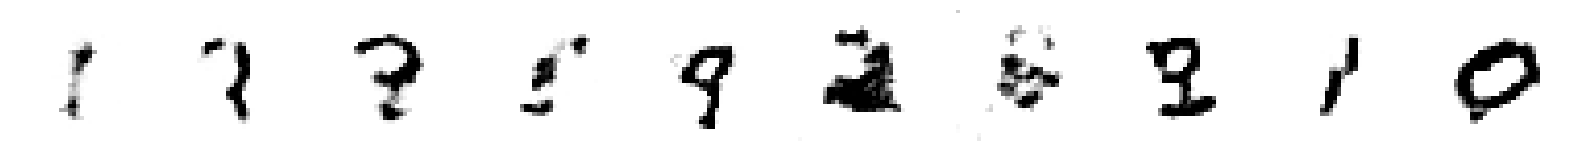

469/469 [==============================] - 561s 1s/step - loss: -2.3645e-05 - reg: 2.4058e-04 - cdiv: -2.6422e-04 - real: 5.0584e-04 - fake: 2.4162e-04 - val_cdiv: -5.4947 - val_real: 0.0175 - val_fake: -5.4772
Epoch 13/60
469/469 [==============================] - ETA: 0s - loss: 1.2785e-04 - reg: 2.7681e-04 - cdiv: -1.4896e-04 - real: 2.7014e-04 - fake: 1.2118e-04
Saved to ./output/generated_img_012.png


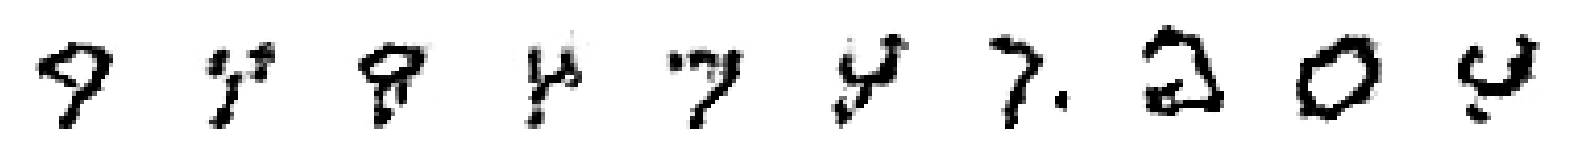


Saved to ./output/example_img_012.png


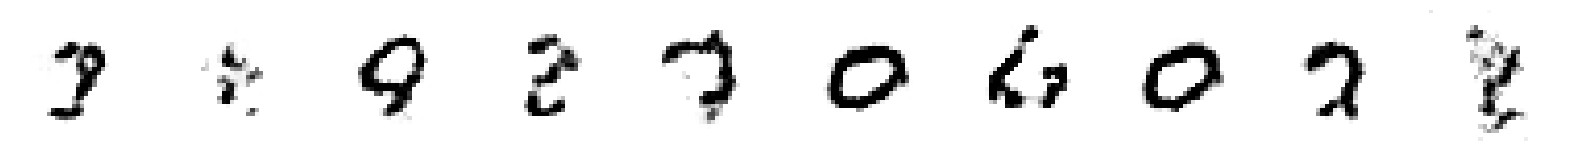

469/469 [==============================] - 560s 1s/step - loss: 1.2785e-04 - reg: 2.7681e-04 - cdiv: -1.4896e-04 - real: 2.7014e-04 - fake: 1.2118e-04 - val_cdiv: -5.8797 - val_real: 0.0134 - val_fake: -5.8662
Epoch 14/60
219/469 [=============>................] - ETA: 4:46 - loss: -2.6880e-04 - reg: 2.9711e-04 - cdiv: -5.6590e-04 - real: 0.0012 - fake: 6.5117e-04    

KeyboardInterrupt: 

In [42]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        tensorboard_callback,
        image_generator_callback,
    ],
)

## Generating Images

In [52]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

In [54]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=5000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_imgs_per_step=True,
)

In [55]:
gen_img.shape

TensorShape([5000, 10, 32, 32, 1])

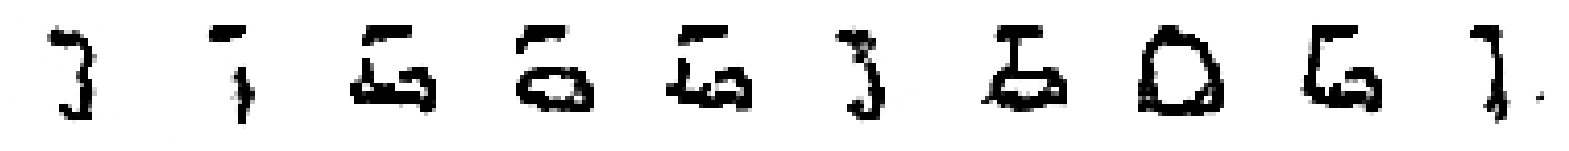

In [56]:
display(gen_img[-1].numpy())

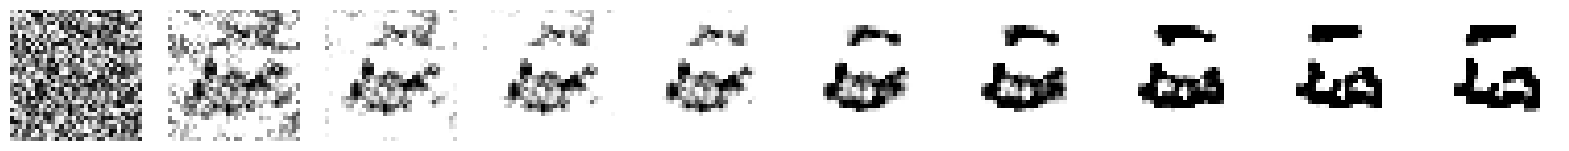

In [59]:
imgs = []
for i in [0, 10, 30, 50, 100, 300, 500, 1000, 3000, 4999]:
    imgs.append(gen_img[i].numpy()[4])

display(np.array(imgs))